This file is the post-processing script for GPT-4o generated content.

In [48]:
import json
import os
import pprint 
import re
pp = pprint.PrettyPrinter(indent=4)

# dataset_name = 'meme_retrieval_data'
# dataset_name = 'figmemes'
dataset_name = 'figmemes'

# file_suffix = "_1-1537_figmemes_multi_labels"
file_suffix = "_templatic_with_about_section"

img_prompt_respond_file = ''
if dataset_name == 'meme_retrieval_data':
    img_prompt_respond_file = '../data/meme_retrieval_data/img_prompt_respond_1-33283.json' # img_prompt_respond_1-33283.json
elif dataset_name == 'figmemes':
    img_prompt_respond_file = f'../data/figmemes/img_prompt_respond{file_suffix}.json'
elif  dataset_name == 'memecap':
    img_prompt_respond_file = '../data/memecap/img_prompt_respond_1-559_memecap.json'

meme_configs = []
with open(img_prompt_respond_file, 'r', encoding='utf-8') as json_file:
    meme_configs = json.load(json_file)
len(meme_configs)


16

In [49]:
if dataset_name == 'meme_retrieval_data' or dataset_name == 'memecap':
    literary_device = set("sarcasm, allegory, alliteration, allusion, amplification, anagram, analogy, anthropomorphism, antithesis, chiasmus, circumlocution, euphemism, hyperbole, imagery, metaphor, onomatopoeia, oxymoron, paradox, personification, portmanteau, pun, satire, simile, symbolism, none".split(', '))
elif dataset_name == 'figmemes':
    literary_device = set("allusion, exaggeration, irony, anthrop, metaphor, contrast".split(', '))

emotion_word = set("fear, anger, joy, sadness, surprise, disgust, guilt, contempt, shame, embarrassment, envy, jealousy, love, hate, interest, none".split(', '))
literary_device, emotion_word, len(literary_device), len(emotion_word)

({'allusion', 'anthrop', 'contrast', 'exaggeration', 'irony', 'metaphor'},
 {'anger',
  'contempt',
  'disgust',
  'embarrassment',
  'envy',
  'fear',
  'guilt',
  'hate',
  'interest',
  'jealousy',
  'joy',
  'love',
  'none',
  'sadness',
  'shame',
  'surprise'},
 6,
 16)

# Extract responses into JSON objects 

In [50]:
import re
import json
correction_map = {'anthropomorphism':'anthrop', 'dehumanizing metaphor': 'metaphor'}

counter = 0
meme_annotations = []
invalid_labels = []
number_of_invalid_labels = 0
for i, meme in enumerate(meme_configs):
    new_meme_conf = {}
    new_meme_conf["image_dir"] = meme["image_dir"]
    new_meme_conf["prompt"] = meme["prompt"]
    x = re.sub("```.*\n", "", meme['respond'])
    x = re.sub("```", "", x)
    x = x.strip()
    try:
        y = json.loads(x)
        y["literary device"] = [device.lower() for device in y["literary device"] if device.lower() != 'none']
        # y["literary device"].remove('none')
        valid = True
        for idx in range(len(y['literary device'])):
            device = y['literary device'][idx]
            if device not in literary_device:
                if device in correction_map.keys():
                    y['literary device'][idx] = correction_map[device]
                    # print('Correcttion: ', device, correction_map[device])
                else:
                    valid = False   
                    print(y['literary device'])
                    invalid_labels.append(device)
        if valid:
            new_meme_conf.update(y)
            meme_annotations.append(new_meme_conf) # Merge two dictionaries
            counter += 1
        else:
            number_of_invalid_labels += 1
    except:
        pass 
    
'''
{
  "detected text": "My Brother's Husband Is the Hottest Family-Friendly Manga Ever Made by Chase Burns · Feb 11, 2020 at 1:00 pm KIDS ARE LUCKY. THEY DON'T HAVE TO THINK ABOUT THAT STUFF.",
  "meaning of the meme": "The meme showcases a perceived irony where a manga titled 'My Brother's Husband,' featuring themes that might not traditionally be considered family-friendly, is touted as the 'hottest family-friendly manga.' It draws attention to the juxtaposition between the term 'family-friendly' and the content of the manga which deals with complex social issues such as same-sex relationships. The character's dialog emphasizes the innocence of children who do not have to grapple with the social complexities explored in the manga.",
  "literary device": ["Irony", "Contrast"]
}
'''
print(counter, number_of_invalid_labels, len(meme_annotations))
print(set(invalid_labels))
meme_annotations[0]

16 0 16
set()


{'image_dir': './data/figmemes/images/1632045519218.png',
 'prompt': 'Warning: We discuss and show memes that may be offensive to readers for research purposes only. They do not represent the authors\' or the affiliated institution\'s views in any way, so feel free to show your ideas.\n Here is the introduction of the template behind the meme:\nFrenworld was a subreddit in which Redditors submitted illustrations of the Pepe the Frog variant Apu Apustaja in posts written in childlike speech, such as using the word fren in place of \\friend.\\" While many of the posts submitted to /r/Frenworld contained what appeared to be wholesome content, many accused the community members of using dog whistles to promote bigotry and violence. The subreddit was banned in June 2019 for violating Reddit\'s content guidelines.".\n\nYou are going to finish the following tasks. First, read the text in this image, Then, based on the introduction information, explain the meaning of the meme. Finally, based o

In [51]:
print("{\n  \"detected text\": \"NASA REVEALS SATURN IS ACTUALLY BIG NIGGA WITH HULA HOOP. The world is shocked...what else is the government hiding from us.\",\n  \"meaning of the meme\": \"The meme humorously claims that the planet Saturn is actually an obese Black man (referred to as 'Big Nigga') who is holding a hula hoop, which represents Saturn's rings. This is a satirical commentary employing surreal and absurd imagery to mock the idea of hidden truths or conspiracies revealed by authoritative sources like NASA.\",\n  \"literary device\": [\"Exaggeration\", \"Irony\", \"Allusion\"]\n}")

{
  "detected text": "NASA REVEALS SATURN IS ACTUALLY BIG NIGGA WITH HULA HOOP. The world is shocked...what else is the government hiding from us.",
  "meaning of the meme": "The meme humorously claims that the planet Saturn is actually an obese Black man (referred to as 'Big Nigga') who is holding a hula hoop, which represents Saturn's rings. This is a satirical commentary employing surreal and absurd imagery to mock the idea of hidden truths or conspiracies revealed by authoritative sources like NASA.",
  "literary device": ["Exaggeration", "Irony", "Allusion"]
}


In [52]:
# Save JSON file
print(len(meme_annotations))
with open(f'../data/figmemes/filtered_meme_configs{file_suffix}.json', "w") as outfile: 
      json.dump(meme_annotations, outfile, indent=4)

16


# Statistics and post-check

In [53]:
def str_length_statistics(dataset):
    # ic_label_length = []
    dt_label_length = []
    mc_label_length = []
    ld_label_length = []
    # ew_label_length = []

    for ite in dataset:
        dt_label_length.append(len(ite['detected text'].split()))
        mc_label_length.append(len(ite['meaning of the meme'].split()))
        ld_label_length.append(len(ite['literary device']))

    print(set(dt_label_length))
    print(set(mc_label_length))
    print(set(ld_label_length)) # Good, only 1

    import pandas as pd
    import matplotlib.pyplot as plt
    # Create a DataFrame from the lists
    data = {
        'detected text': dt_label_length,
        'meaning of the meme': mc_label_length,
        'literary device': ld_label_length,
    }
    df = pd.DataFrame(data)

    # Display the DataFrame
    print(df)

    # Plot a boxplot
    plt.figure(figsize=(10, 6))
    df.boxplot()
    plt.title('The distribution of the lengths of responses')
    plt.ylabel('No. of words')
    plt.show()


16
{0, 1, 3, 5, 6, 8, 13, 21}
{34, 35, 36, 38, 71, 41, 73, 47, 48, 51, 54, 55, 57, 31}
{1, 2, 3}
    detected text  meaning of the meme  literary device
0               1                   48                1
1              21                   54                3
2               1                   51                2
3               0                   41                2
4               0                   31                2
5               1                   35                1
6               0                   51                2
7               1                   38                2
8               8                   55                2
9               3                   36                2
10              0                   71                3
11              5                   73                3
12              0                   47                3
13              6                   31                1
14              0                   57                3
15     

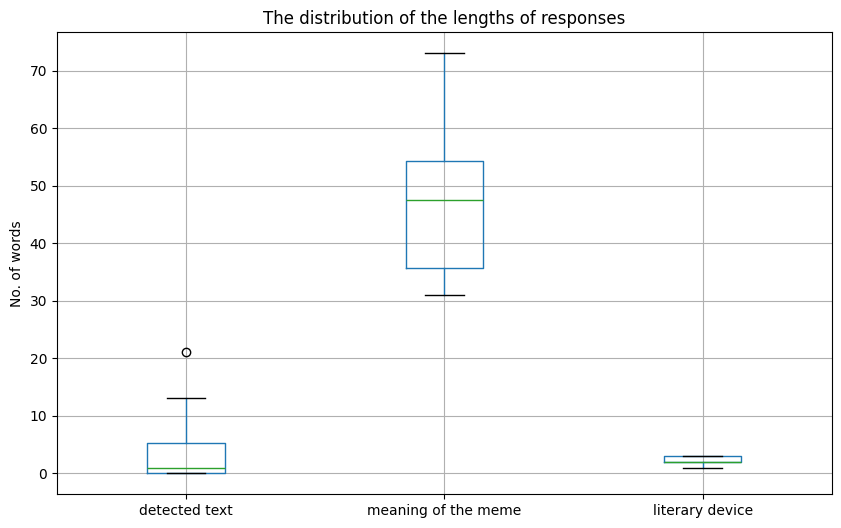

In [54]:
print(len(meme_annotations))
str_length_statistics(meme_annotations)

# Label distribution

In [55]:
from collections import defaultdict

literary_device_label_dict = defaultdict(lambda: 0)
# emotion_label_dict= defaultdict(lambda: 0)

for idx, meme_conf in enumerate(meme_annotations):
    for device in meme_conf['literary device']:
        literary_device_label_dict[device] += 1
pp.pprint(literary_device_label_dict)

defaultdict(<function <lambda> at 0x7fe5391b7f40>,
            {   'allusion': 7,
                'anthrop': 5,
                'contrast': 2,
                'exaggeration': 8,
                'irony': 9,
                'metaphor': 3})


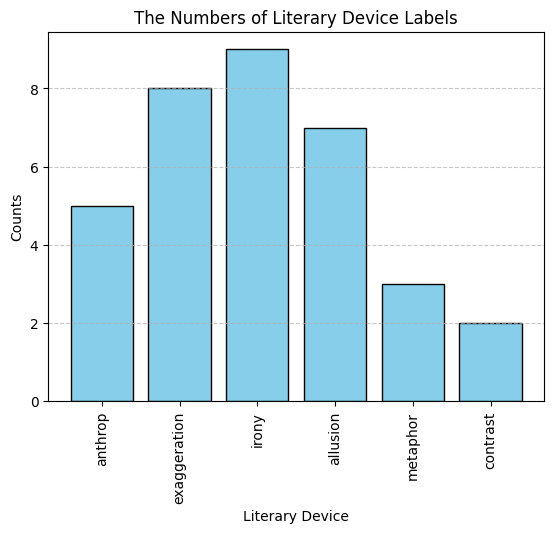

In [56]:
import matplotlib.pyplot as plt

# Extract the keys and values from the dictionary
keys = list(literary_device_label_dict.keys())
values = list(literary_device_label_dict.values())

# Plot a bar chart
# plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='skyblue', edgecolor='black')
plt.xticks(rotation=90)

plt.title('The Numbers of Literary Device Labels')
plt.xlabel('Literary Device')
plt.ylabel('Counts')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()
